<center><h1>Model V2: Model solving cold-start problem</h1></center>

사용자-아이템 행렬 이외의 정보를 활용하여서 추천 시스템을 개선한다. 특히 Model V1에서는 학습 데이터에 없지만 테스트 데이터에 있는 사용자 또는 노래에 대해서 target 값을 0으로 일괄 처리했다. 제공된 다른 정보를 활용하여서 정교한 추천 모델을 만들어 사용자가 노래를 한 달 안에 다시 들을지 예측한다.

최종 제출 결과: 0.58346 (Public), 0.58293 (Private)

---

## Table of Contents
1. [Environment Settings](#1)
    * [Import Library](#1.1)
    * [Load Dataset](#1.2)
2. [Pre-Process Dataset](#2)
    1. [members.csv](#2.1)
    2. [songs.csv](#2.2)
3. [Join Dataset](#3)
4. [Data Modeling](#4)
    * [Split Train and Validation](#4.1)
    * [Dataframe to CSR_Matrix: user-song matrix](#4.2)
    * [Dataframe to Matrix: features](#4.3)
    * [Matrix Factorization](#4.4)
    * [Neural Modeling](#4.5)

----

## 1. Environment Settings <a id="1"></a>

### Import Library <a id="1.1"><a/>

In [1]:
# Collection Counter
from collections import Counter

# Linear Algebra
import numpy as np

# Dataframe
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# FOR Loop Verbose
from tqdm import tqdm

# CSR Matrix
from scipy.sparse import csr_matrix

# Matrix Facorization
from sklearn.decomposition import TruncatedSVD

# Nueral Network
import tensorflow as tf
from tensorflow import keras

In [2]:
pd.options.display.max_columns = 499
pd.options.display.max_rows = 499
pd.options.mode.chained_assignment = None

In [3]:
fname = '../static/fonts/D2Coding.ttc'
ffamily = fm.FontProperties(fname=fname).get_name()
plt.rcParams['font.family'] = ffamily
plt.rcParams['font.size'] = 14

In [4]:
plt.style.use(['seaborn-darkgrid'])

In [5]:
%matplotlib inline

### Load Dataset <a id="1.2"></a>

In [6]:
# train.csv와 test.csv는 정제된(pre-processing) 데이터를 사용한다.
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

songs = pd.read_csv('../data/songs.csv')
members = pd.read_csv('../data/members.csv')

## 2. Pre-Process Dataset <a id="2"></a>

### 1. members.csv <a id="2.1"></a>

members.csv에 있는 변수(열)는 [city](#2.1.1), [bd](#2.1.2), [gender](#2.1.3), [registered_via](#2.1.4), [registration_init_time](#2.1.5), [expiration_date](#2.1.6) 이다. 각 변수는 다음과 같이 전처리한다.

1. **city**
    * Missing Value(누락된 값) 없음
    * 21개의 카테고리 -> One Hot으로 만들기에는 개수가 많으므로 카테고리 통합 필요.
    * 도시 1의 사용자가 가장 많음.
    * 도시 1 출신과 나머지 도시 출신으로 재그룹화해서 feature로 채택
2. bd
    * Missing Value(누락된 값) 없음
    * Outlier(이상치) 많음. 상식적으로 나이는 0에서 100세 사이. 
    * 이상치 문제가 있으므로 feature 채택하지 않음
3. gender
    * Missing Value(누락된 값) 많음
    * 누락된 값이 많으므로 feature 채택하지 않음
4. **registered_via**
    * Missing Value(누락된 값) 없음
    * 6개의 카테고리
    * feature로 채택
5. **registration_init_time**
    * Missing Value(누락된 값) 없음
    * 연도만 feature로 채택
6. expiration_date
    * Missing Value(누락된 값) 없음
    * Outlier(이상치)로 추정되는 값 있음. 최소값이 1970년인데 이는 상식적으로 맞지 않음
    * 이상치 문제가 있ㅇ므ㅡ로 feature 채택하지 않음

In [7]:
members_proc = members.copy()

In [8]:
members_proc.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [9]:
members_proc.isna().sum()

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

### 1) city <a id="2.1.1"></a>

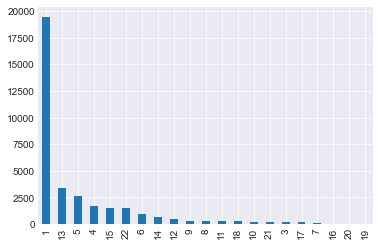

In [10]:
members_proc.city.value_counts().plot(kind='bar')

In [11]:
members_proc['from_city_1'] = members_proc.city.apply(lambda x: int(x) if int(x) == 1 else 0)

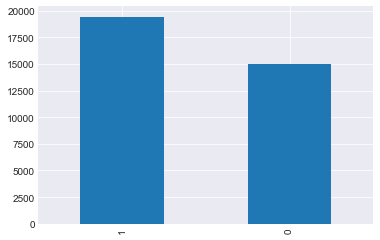

In [12]:
members_proc.from_city_1.value_counts().plot(kind='bar')

### 2) bd <a id="2.1.2"></a>

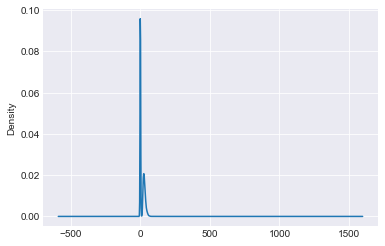

In [13]:
members_proc.bd.plot(kind='kde')

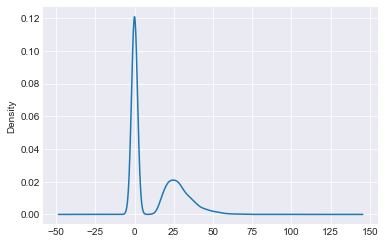

In [14]:
members_proc.loc[members_proc.bd.isin(range(0, 101)), 'bd'].plot(kind='kde')

In [15]:
members_proc.loc[members_proc.bd == 0, 'bd'].count() / members_proc.bd.count()

0.5793680783652588

### 3) gender <a id="2.1.3"></a>

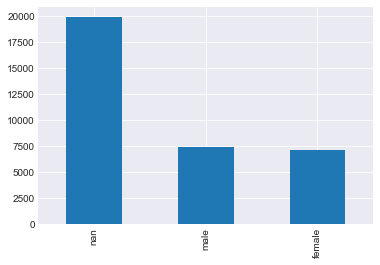

In [16]:
members_proc.gender.value_counts(dropna=False).plot.bar()

### 4. registerd_via <a id="2.1.4"></a>

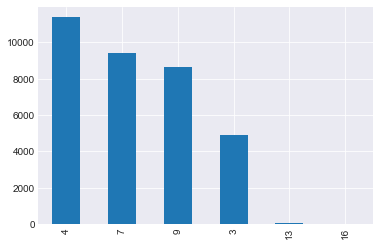

In [17]:
members_proc.registered_via.value_counts().plot.bar()

### 5) registration_init_time <a id="2.1.5"></a>

In [18]:
members_proc['registration_init_time_year'] = pd.to_datetime(members_proc.registration_init_time, format='%Y%m%d').dt.year

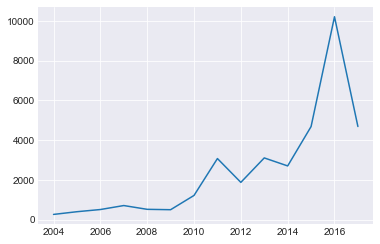

In [19]:
members_proc.registration_init_time_year.value_counts().sort_index().plot()

In [20]:
members_proc.registration_init_time.max()

20170228

### 6) expiration_date <a id="2.1.6"></a>

In [21]:
members_proc['expiration_date_year'] = pd.to_datetime(members_proc.expiration_date, format='%Y%m%d').dt.year

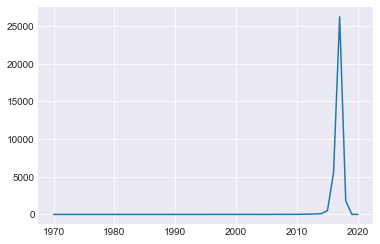

In [22]:
members_proc.expiration_date_year.value_counts().sort_index().plot()

In [23]:
members_proc.expiration_date.min()

19700101

In [24]:
members_proc.expiration_date.max()

20201017

### Pre-Process members.csv

In [25]:
members_proc.drop(columns=['city', 'bd', 'gender', 'registration_init_time', 'expiration_date', 'expiration_date_year'], inplace=True)

In [26]:
members_proc = pd.get_dummies(members_proc, columns=['registered_via', 'registration_init_time_year'])

In [28]:
members_proc.sample(10)

,msno,from_city_1,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,registered_via_16,registration_init_time_year_2004,registration_init_time_year_2005,registration_init_time_year_2006,registration_init_time_year_2007,registration_init_time_year_2008,registration_init_time_year_2009,registration_init_time_year_2010,registration_init_time_year_2011,registration_init_time_year_2012,registration_init_time_year_2013,registration_init_time_year_2014,registration_init_time_year_2015,registration_init_time_year_2016,registration_init_time_year_2017
15551,KiOEI4E5/PAUuyq09a0NHPCiqA1Gq9GqO0ECVq6ipfU=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33209,eSkNLhSuVAPIFy5tEECrdMedRWSb2F2H7Sh146ktyaY=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
31037,efob0tHfLpBj6Ycugf23HFvtTGiHBw8kw1paYd7zGNo=,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4511,K9FQ/PvbF78A0pAT1UGntGKyzDYL+6Lo4sOBQ/NEJeA=,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28231,THRnoe6r6Yj7hTEHpeF1Vr/YYI3ssnKpoGNNnpQV4Bw=,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
19985,X6ZvVin9yQkbIvNRYQdKjKgSgaVLGTUZwGNRC69uJbU=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7660,PFLNQ6u2J1rW702Y2sCqGQaStlcFgCS4pxNafNCDDXo=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25717,0nBlcwrdD8fkcHZmLYoELNboBYwhcFbjpPfF6WxRvyM=,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17737,2G/oxOUo8EPgH0hUujR7laC/MYKme56/Au9Ww10yyEI=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15384,LE6tzCp/TtkGxNKH/kLVxyHyBHjPP2rrQHGSJCjywiU=,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [29]:
members_proc.to_csv('../data/processed/members-model-v2.csv', index=False)

### 2. songs.csv <a id="2.2"></a>

songs.csv에 있는 변수(열)는 [song_length](#2.2.1), [genre_ids](#2.2.2), artist_name, composer, lyricist, [language](#2.2.3) 이다. 각 변수는 다음과 같이 전처리한다.

1. **song_length**
    * Missing Value(누락된 값) 없음
    * 1,000,000(약 15)분을 넘는 긴 노래도 있지만 전체적으로는 3~4분.
    * 동일 크기로 bin을 나누어서 계급화.
2. **genre_ids**
    * Missing Value(누락된 값) 없음
    * 두 개 이상의 genre_id가 \|로 연결되어 있음 
    * 10,000 건 이상 참조된 장르에 대해서는 카테고리 생성
3. artist_name, composer, lyricist
    * composer, lyricist는 Missing Value(누락된 값) 있음
    * 전체적으로 fetuare로 선택하기 어려움
4. **language**
    * Missing Value(누락된 값) 있음 -> 한 건으로 확인 결과 31.0에 해당
    * 10개의 카테고리
    * feature로 채택

In [30]:
songs_proc = songs.copy()

In [31]:
songs_proc.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [32]:
songs_proc.isna().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

### 1) song_length <a id="2.2.1"></a>

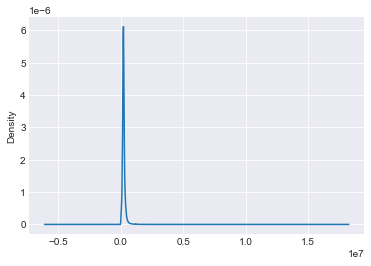

In [33]:
songs_proc.song_length.plot(kind='kde')

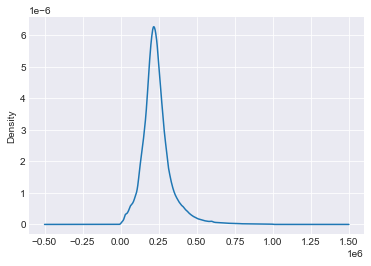

In [34]:
songs_proc.loc[songs_proc.song_length.isin(range(0, 1000000)), 'song_length'].plot(kind='kde')

In [35]:
songs_proc['song_length_bin'], bins = pd.qcut(songs_proc.song_length, 5, labels=False, retbins=True)
songs_proc.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,song_length_bin
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,3
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,2
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,3
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,0


In [36]:
bins

array([1.850000e+02, 1.718280e+05, 2.106510e+05, 2.435650e+05,
       2.938710e+05, 1.217385e+07])

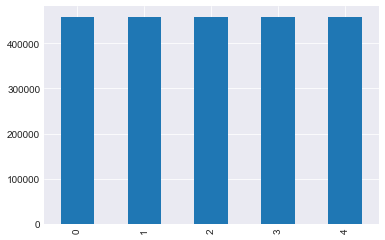

In [37]:
songs_proc.song_length_bin.value_counts().sort_index().plot(kind='bar')

### 2) genre_ids <a id="2.2.2"></a>

In [38]:
genres = list()
for g in tqdm(songs_proc.genre_ids):
    genres += g.split('|') if not pd.isna(g) else []
counter = Counter(genres)
counter.most_common(10)

100%|██████████| 2296320/2296320 [00:02<00:00, 976194.62it/s]


[('465', 589220),
 ('958', 182836),
 ('1609', 177258),
 ('2022', 176531),
 ('2122', 149608),
 ('1259', 103904),
 ('921', 74983),
 ('1152', 65463),
 ('786', 59438),
 ('139', 56405)]

In [39]:
top_genres = list(map(lambda x: x[0], filter(lambda x: x[1] > 100000, counter.items())))
top_genres

['465', '1609', '2022', '2122', '1259', '958']

In [40]:
for top_g in tqdm(top_genres):
    column_name = 'genre_{}'.format(top_g)
    values = list()
    for g in songs_proc.genre_ids:
        value = 0
        if not pd.isna(g) and top_g in g.split('|'):
            value = 1
        values.append(value)
    songs_proc[column_name] = values
songs_proc

100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,song_length_bin,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,3,1,0,0,0,0,0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1,0,0,0,0,0,0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,2,1,0,0,0,0,0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,3,1,0,0,0,0,0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0,0,0,0,0,0,0,1
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0,3,1,0,0,0,0,0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0,4,0,1,0,0,0,0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0,1,1,0,0,0,0,0


### 3) language <a id="2.2.3"></a>

In [41]:
songs_proc[songs_proc.language.isna()]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,song_length_bin,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958
605127,nMZ7IRARPBit0ZGegNfecsx77LQSpH2ZY93vyd5xRy0=,178654,444,JONGHYUN,Korean Lyrics by Kim| Jong Hyun / Lee| Yoon Se...,31,NaN,1,0,0,0,0,0,0


In [42]:
songs_proc.language.fillna(31, inplace=True)

In [43]:
songs_proc[songs_proc.language.isna()]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,song_length_bin,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958


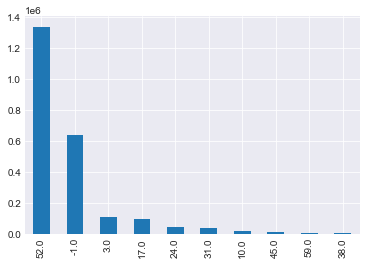

In [44]:
songs_proc.language.value_counts().plot(kind='bar')

### Pre-Process songs.csv

In [45]:
songs_proc.drop(columns=['song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist'], inplace=True)

In [46]:
songs_proc = pd.get_dummies(songs_proc, columns=['song_length_bin', 'language'])

In [47]:
songs_proc.sample(10)

,song_id,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958,song_length_bin_0,song_length_bin_1,song_length_bin_2,song_length_bin_3,song_length_bin_4,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0
1492559,A9HVQttfaeMLh13UJhfOGJa918TrzV4EtlziIW8xnZc=,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1431787,GE3mODPF+t6g7lXG/DazCoJFic+ylRarakFvB9Zf6+I=,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
571346,TvtA6GvdWwNH6ScL4VPmwrcCcd5G4iycnhzvBc8Np2s=,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1076546,uqvNCaCBAhZ9ck6SW2z7B4tF5Z0uGVsmwt2WnebQqxc=,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1288017,UBFNbCGoilexdWRMska9xIn9FiLuofCh7oTKDKbBueg=,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1891313,B1fPRaUx2tSBpgAVMQPg7StOdoBGu8RiW59CRV56WKc=,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
616772,iRRB31GX7LjOliP0DDQIf03f/3sH/PQWynHENwM2dv8=,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
906473,KgzXlqu6TZGkMNDAhgkzIU+q8869IGofk7/jcVEOSpg=,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2088822,LUJw02BsFJCKbiw5+0pnGWMGZ3HGejhczi8+vTwqJos=,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1722117,zY9R1N8rOmPYgJ27SuovLoNFjJXMRih0dI6+O1UDCXY=,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [48]:
songs_proc.to_csv('../data/processed/songs-model-v2.csv', index=False)

## Join Datasets <a id="3"></a>

In [104]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

songs = pd.read_csv('../data/processed/songs-model-v2.csv')
members = pd.read_csv('../data/processed/members-model-v2.csv')

In [105]:
def left_join_dataframe(df, songs, members):
    df = pd.merge(left=df, right=members, how='left', on='msno')
    df = pd.merge(left=df, right=songs, how='left', on='song_id')

    df.fillna(0, inplace=True)

    columns = df.select_dtypes(include='float').columns
    df.loc[:, columns] = df.loc[:, columns].astype(int)

    return df

In [106]:
train = left_join_dataframe(train, songs, members)
test = left_join_dataframe(test, songs, members)

In [107]:
test.sort_values('id', inplace=True)
test.reset_index(drop=True, inplace=True)

In [108]:
train = pd.get_dummies(train, columns=['source_system_tab', 'source_screen_name', 'source_type'])
test = pd.get_dummies(test, columns=['source_system_tab', 'source_screen_name', 'source_type'])

In [109]:
columns = list(train.columns)
idx = columns.index('target')
columns = columns[:idx] + columns[idx + 1:] + ['target']
train = train[columns]

In [110]:
assert list(train.columns[:-1]) == list(test.columns[1:])

In [111]:
train.shape

(7377418, 58)

In [112]:
test.shape

(2556790, 58)

In [113]:
train.head()

,msno,song_id,from_city_1,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,registered_via_16,registration_init_time_year_2004,registration_init_time_year_2005,registration_init_time_year_2006,registration_init_time_year_2007,registration_init_time_year_2008,registration_init_time_year_2009,registration_init_time_year_2010,registration_init_time_year_2011,registration_init_time_year_2012,registration_init_time_year_2013,registration_init_time_year_2014,registration_init_time_year_2015,registration_init_time_year_2016,registration_init_time_year_2017,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958,song_length_bin_0,song_length_bin_1,song_length_bin_2,song_length_bin_3,song_length_bin_4,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0,source_system_tab_REMOVED,source_system_tab_discover,source_system_tab_my library,source_system_tab_radio,source_screen_name_Local playlist more,source_screen_name_Online playlist more,source_screen_name_REMOVED,source_screen_name_Radio,source_type_REMOVED,source_type_local-library,source_type_local-playlist,source_type_online-playlist,source_type_radio,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1


In [114]:
test.head()

,id,msno,song_id,from_city_1,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,registered_via_16,registration_init_time_year_2004,registration_init_time_year_2005,registration_init_time_year_2006,registration_init_time_year_2007,registration_init_time_year_2008,registration_init_time_year_2009,registration_init_time_year_2010,registration_init_time_year_2011,registration_init_time_year_2012,registration_init_time_year_2013,registration_init_time_year_2014,registration_init_time_year_2015,registration_init_time_year_2016,registration_init_time_year_2017,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958,song_length_bin_0,song_length_bin_1,song_length_bin_2,song_length_bin_3,song_length_bin_4,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0,source_system_tab_REMOVED,source_system_tab_discover,source_system_tab_my library,source_system_tab_radio,source_screen_name_Local playlist more,source_screen_name_Online playlist more,source_screen_name_REMOVED,source_screen_name_Radio,source_type_REMOVED,source_type_local-library,source_type_local-playlist,source_type_online-playlist,source_type_radio
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [115]:
train.to_csv('../data/processed/train-model-v2.csv', index=False)
test.to_csv('../data/processed/test-model-v2.csv', index=False)

In [116]:
corelation_matrix = train.corr()
corelation_matrix.target

from_city_1                               -0.020539
registered_via_3                           0.009539
registered_via_4                          -0.031332
registered_via_7                           0.003115
registered_via_9                           0.009151
registered_via_13                         -0.001419
registered_via_16                               NaN
registration_init_time_year_2004          -0.004572
registration_init_time_year_2005          -0.001176
registration_init_time_year_2006           0.008202
registration_init_time_year_2007          -0.003433
registration_init_time_year_2008          -0.006397
registration_init_time_year_2009           0.002952
registration_init_time_year_2010          -0.004782
registration_init_time_year_2011          -0.001421
registration_init_time_year_2012          -0.002827
registration_init_time_year_2013           0.007053
registration_init_time_year_2014           0.012727
registration_init_time_year_2015           0.014134
registration

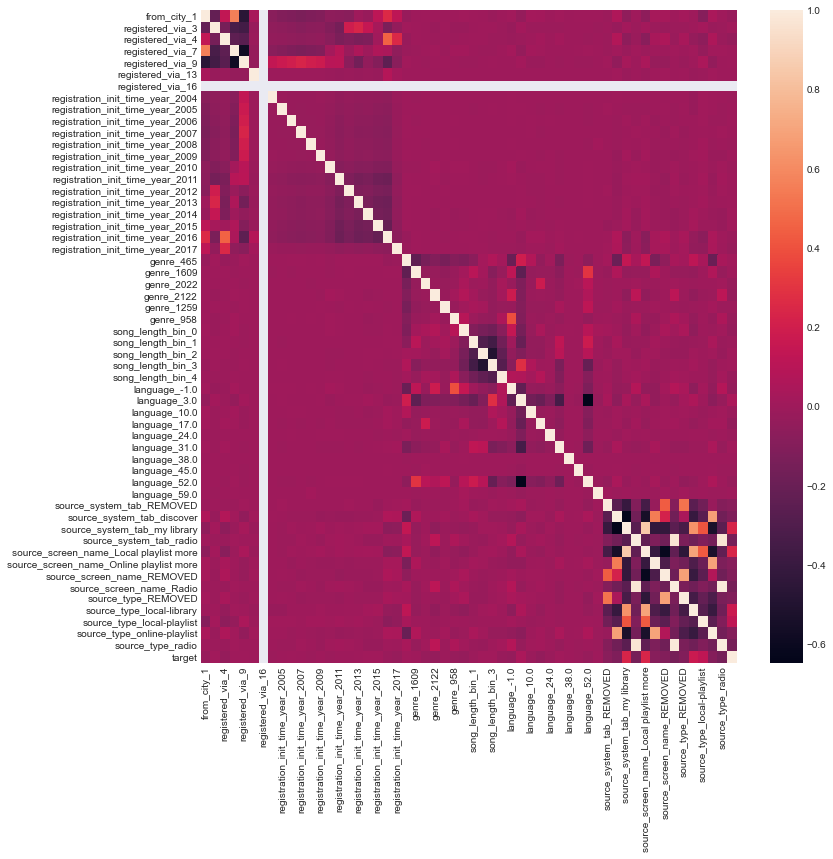

In [117]:
plt.figure(figsize=(12, 12))
sns.heatmap(corelation_matrix)
plt.show()

## 4. Data Modeling <a id="4"></a>

### Split Train and Validation <a id="4.1"></a>

In [118]:
def split_train_and_validation(train):
    validation = train.sample(frac=0.1, random_state=2020)
    train.drop(validation.index, axis=0, inplace=True)

    train.reset_index(drop=True, inplace=True)
    validation.reset_index(drop=True, inplace=True)

    return train, validation

In [119]:
train, validation = split_train_and_validation(train)

In [120]:
train.shape

(6639676, 58)

In [121]:
validation.shape

(737742, 58)

In [122]:
train.head()

,msno,song_id,from_city_1,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,registered_via_16,registration_init_time_year_2004,registration_init_time_year_2005,registration_init_time_year_2006,registration_init_time_year_2007,registration_init_time_year_2008,registration_init_time_year_2009,registration_init_time_year_2010,registration_init_time_year_2011,registration_init_time_year_2012,registration_init_time_year_2013,registration_init_time_year_2014,registration_init_time_year_2015,registration_init_time_year_2016,registration_init_time_year_2017,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958,song_length_bin_0,song_length_bin_1,song_length_bin_2,song_length_bin_3,song_length_bin_4,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0,source_system_tab_REMOVED,source_system_tab_discover,source_system_tab_my library,source_system_tab_radio,source_screen_name_Local playlist more,source_screen_name_Online playlist more,source_screen_name_REMOVED,source_screen_name_Radio,source_type_REMOVED,source_type_local-library,source_type_local-playlist,source_type_online-playlist,source_type_radio,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
3,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
4,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [123]:
validation.head()

,msno,song_id,from_city_1,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,registered_via_16,registration_init_time_year_2004,registration_init_time_year_2005,registration_init_time_year_2006,registration_init_time_year_2007,registration_init_time_year_2008,registration_init_time_year_2009,registration_init_time_year_2010,registration_init_time_year_2011,registration_init_time_year_2012,registration_init_time_year_2013,registration_init_time_year_2014,registration_init_time_year_2015,registration_init_time_year_2016,registration_init_time_year_2017,genre_465,genre_1609,genre_2022,genre_2122,genre_1259,genre_958,song_length_bin_0,song_length_bin_1,song_length_bin_2,song_length_bin_3,song_length_bin_4,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0,source_system_tab_REMOVED,source_system_tab_discover,source_system_tab_my library,source_system_tab_radio,source_screen_name_Local playlist more,source_screen_name_Online playlist more,source_screen_name_REMOVED,source_screen_name_Radio,source_type_REMOVED,source_type_local-library,source_type_local-playlist,source_type_online-playlist,source_type_radio,target
0,QTwsBNF1Ie0JhgQ5i27OOyen2u+0K3j9cR7l0ZZeAbY=,iilqYfHUSf7ETyPvZwZoWBojhFcuOWynMeQoPBnj0/k=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,KajqbnA4RNFsunR/CBqtAaZlGyAllRxwllcPl6uq51s=,R1jBDtkVrNl3ZnI2wDe0RvFtZFgrbnqm4TKqIBAwggU=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,E23IyF1NtT7IeesuDuHWR6g/yMpWrq3cN3U4qTjXE0A=,oMxvz7pKsR8szUiju1K+z8VYJGW32F4yQhN4bGReVZQ=,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
3,EK5AQ01IjtrIvuIlFSS3AqWC3uJRxEe41nk03g5P05A=,6TvLjCoGlGu2/KYW1V91T8EC6QcAQAfNZWESmslaYqs=,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,3pYMdtwa7iSkanXKHr9eNv9PGQ0/52C0wBnM1TeFxiA=,ULFYHKtgvx6NgJ0oQ9NGDmkG8b4P5lAkkJU+GV9VEb8=,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


### Dataframe to CSR_Matrix: user-song matrix <a id="4.2"></a>

In [124]:
def dataframe_to_user_song_matrix(dataframe):
    users = dataframe.msno.unique()
    songs = dataframe.song_id.unique()

    user2idx = {user: idx for idx, user in enumerate(users)}
    song2idx = {song: idx for idx, song in enumerate(songs)}

    users_idx = np.array(dataframe.msno.map(user2idx))
    songs_idx = np.array(dataframe.song_id.map(song2idx))
    target = np.array(dataframe.target.apply(lambda x: 1 if int(x) == 1 else -1))

    user_song_matrix = csr_matrix((target, (users_idx, songs_idx)))

    return user2idx, song2idx, user_song_matrix

In [125]:
user2idx, song2idx, user_song_matrix = dataframe_to_user_song_matrix(train)
user_song_matrix

<30640x342679 sparse matrix of type '<class 'numpy.longlong'>'
	with 6639676 stored elements in Compressed Sparse Row format>

### Dataframe to Matrix: features <a id="4.3"></a>

In [126]:
def dataframe_to_feature_matrix(dataframe, mode='train'):
    assert mode in ['train', 'test']
    if mode == 'train':
        x = np.array(dataframe.loc[:, dataframe.columns[2:-1]])
        y = np.array(dataframe.loc[:, 'target'])

        return x, y
    else:
        x = np.array(dataframe.loc[:, dataframe.columns[3:]])
        return x

In [127]:
x_train, y_train = dataframe_to_feature_matrix(train)
x_validation, y_validation = dataframe_to_feature_matrix(validation)

In [128]:
assert x_train.shape[0] == len(y_train)
assert x_validation.shape[0] == len(y_validation)
assert x_train.shape[1] == x_validation.shape[1]

In [129]:
x_train.shape

(6639676, 55)

### Matrix Factorization <a id="4.4"></a>

In [130]:
def matrix_factorization(matrix, n_components=100, n_iter=5):
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=2020)

    U = svd.fit_transform(matrix)
    S = np.diag(svd.singular_values_)
    Vt = svd.components_.T

    return svd, U, S, Vt

In [131]:
svd, U, S, Vt = matrix_factorization(user_song_matrix)

In [132]:
U.shape

(30640, 100)

In [133]:
S.shape

(100, 100)

In [134]:
Vt.shape

(342679, 100)

### Neural Modeling <a id="4.5"></a>

In [135]:
class BasicNN(keras.Model):
    def __init__(self):
        super(BasicNN, self).__init__()

        self.dense1 = keras.layers.Dense(10, activation=tf.nn.relu, name='dense1')
        self.dense2 = keras.layers.Dense(1, activation=tf.nn.sigmoid, name='dense2')

    def call(self, inputs):
        hidden = self.dense1(inputs)
        output = self.dense2(hidden)

        return output

In [136]:
model = BasicNN()

In [137]:
temp = keras.Input(shape=(x_train.shape[1]))
model(temp)
model.summary()

Model: "basic_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 10)                560       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
history = model.fit(x=x_train, y=y_train, batch_size=512, epochs=3, verbose=1, validation_data=(x_validation, y_validation))

Epoch 1/3
12969/12969 [==============================] - 17s 1ms/step - loss: 0.6510 - accuracy: 0.6251 - val_loss: 0.6494 - val_accuracy: 0.6265
Epoch 2/3
12969/12969 [==============================] - 13s 1ms/step - loss: 0.6498 - accuracy: 0.6261 - val_loss: 0.6492 - val_accuracy: 0.6264
Epoch 3/3
12969/12969 [==============================] - 13s 1ms/step - loss: 0.6496 - accuracy: 0.6262 - val_loss: 0.6490 - val_accuracy: 0.6268


### Prediction(Recommendataion)

In [140]:
def predict_mf(user, song, S, threshold):
    user = user.reshape(1, -1)
    song = song.reshape(-1, 1)
    rating = np.dot(np.dot(user, S), song)
    return int(rating >= threshold)

In [141]:
real = np.array(validation.target)
scores = {}

for threshold in tqdm(np.arange(-5, 5, 1)):
    prediction = list()
    for user, song in zip(validation.msno, validation.song_id):
        user_idx = user2idx[user] if user in user2idx else -1
        song_idx = song2idx[song] if song in song2idx else -1

        p = predict_mf(U[user_idx], Vt[song_idx], S, threshold) if (user_idx != -1) and (song_idx != -1) else 0
        prediction.append(p)
    prediction = np.array(prediction)
    accuracy = np.mean(np.equal(prediction, real))
    scores[threshold] = accuracy

scores

100%|██████████| 10/10 [02:00<00:00, 12.04s/it]


{-5: 0.5697696484678926,
 -4: 0.575889674167934,
 -3: 0.5838707840952528,
 -2: 0.5946075999468649,
 -1: 0.6118670212621756,
 0: 0.6624172136058405,
 1: 0.6725318607318006,
 2: 0.6657517126583549,
 3: 0.6599393826025901,
 4: 0.6550975815393457}

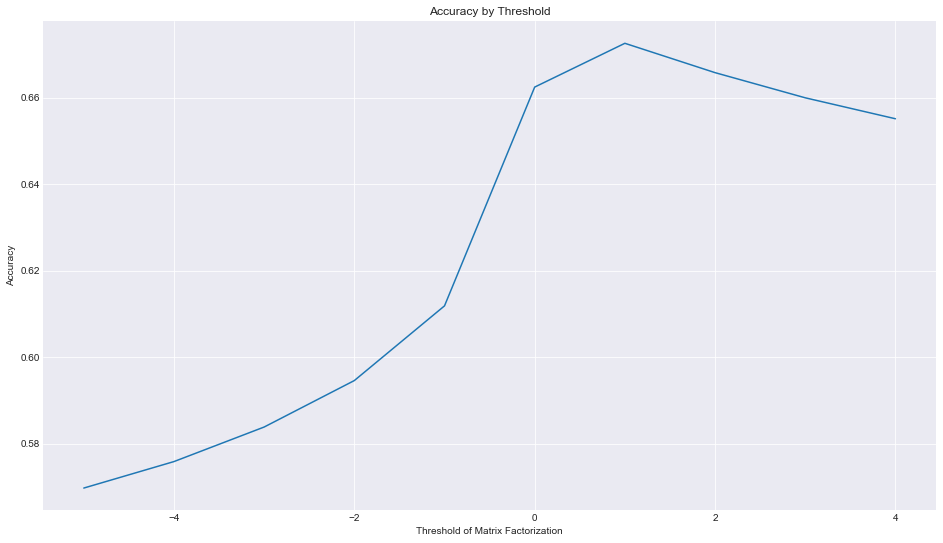

In [142]:
plt.figure(figsize=(16, 9))
plt.plot(list(scores.keys()), list(scores.values()))
plt.xlabel('Threshold of Matrix Factorization')
plt.ylabel('Accuracy')
plt.title('Accuracy by Threshold')
plt.show()

In [143]:
def predict_cold_start(model, x, threshold):
    prediction = model.predict(x) > threshold
    prediction = np.array(list(map(lambda x: int(x), prediction)))
    return prediction

In [144]:
cold_start_index = list()
prediction = list()
for idx, (user, song) in tqdm(enumerate(zip(validation.msno, validation.song_id))):
    user_idx = user2idx[user] if user in user2idx else -1
    song_idx = song2idx[song] if song in song2idx else -1

    if user_idx == -1 or song_idx == -1:
        cold_start_index.append(idx)
        p = 0
    else:
        p = predict_mf(U[user_idx], Vt[song_idx], S, 1)
    prediction.append(p)

prediction = np.array(prediction)
scores = {}
for threshold in tqdm(np.arange(0, 1, 0.1)):
    cold_start_prediction = predict_cold_start(model, validation.loc[cold_start_index, validation.columns[2:-1]], threshold)
    prediction[cold_start_index] = cold_start_prediction

    accuracy = np.mean(np.equal(prediction, real))
    scores[threshold] = accuracy

scores

737742it [00:11, 61883.93it/s]
100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


{0.0: 0.6662410436168742,
 0.1: 0.666242399104294,
 0.2: 0.667336277452009,
 0.30000000000000004: 0.6688205361766038,
 0.4: 0.6714271384847277,
 0.5: 0.6727473832315363,
 0.6000000000000001: 0.6729168191590014,
 0.7000000000000001: 0.6726565655744149,
 0.8: 0.6725332162192202,
 0.9: 0.6725318607318006}

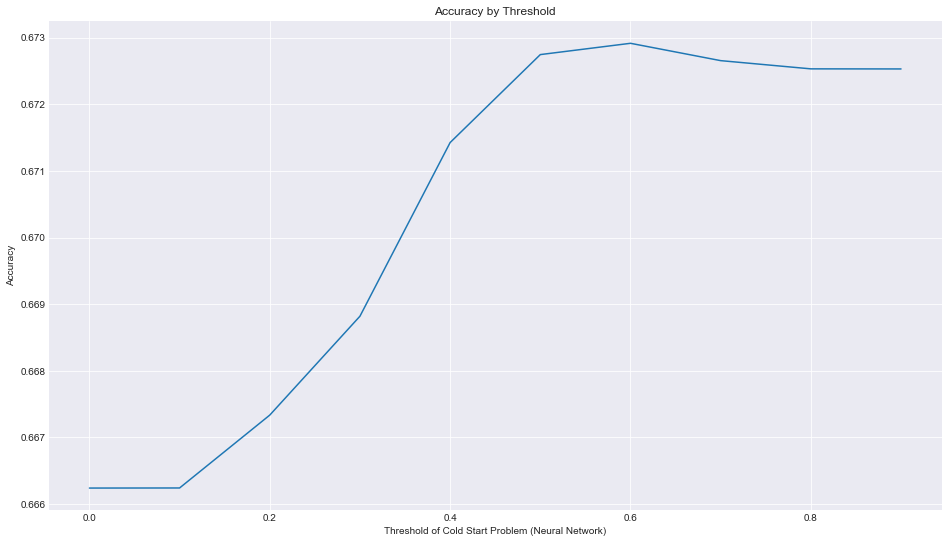

In [145]:
plt.figure(figsize=(16, 9))
plt.plot(list(scores.keys()), list(scores.values()))
plt.xlabel('Threshold of Cold Start Problem (Neural Network)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Threshold')
plt.show()

In [146]:
cold_start_index = list()
prediction = list()
for idx, (user, song) in tqdm(enumerate(zip(validation.msno, validation.song_id))):
    user_idx = user2idx[user] if user in user2idx else -1
    song_idx = song2idx[song] if song in song2idx else -1

    if user_idx == -1 or song_idx == -1:
        cold_start_index.append(idx)
        p = 0
    else:
        p = predict_mf(U[user_idx], Vt[song_idx], S, 1)
    prediction.append(p)

prediction = np.array(prediction)

cold_start_prediction = predict_cold_start(model, validation.loc[cold_start_index, validation.columns[2:-1]], 0.5)
prediction[cold_start_index] = cold_start_prediction

accuracy = np.mean(np.equal(prediction, real))

accuracy

737742it [00:12, 58500.08it/s]


0.6727473832315363

In [147]:
cold_start_index[:10]

[43, 57, 70, 72, 115, 127, 149, 193, 230, 299]

In [152]:
assert validation.loc[43, 'song_id'] not in song2idx or validation.loc[43, 'msno'] not in user2idx

In [155]:
cold_start_prediction[-3]

1

In [156]:
cold_start_index[-3]

737658

In [157]:
prediction[737658]

1

## 5. Submission

In [158]:
train = pd.concat([train, validation], ignore_index=True)
train = train.reset_index(drop=True)
train.shape

(7377418, 58)

In [159]:
user2idx, song2idx, user_song_matrix = dataframe_to_user_song_matrix(train)
user_song_matrix

<30755x359966 sparse matrix of type '<class 'numpy.longlong'>'
	with 7377418 stored elements in Compressed Sparse Row format>

In [160]:
x_train, y_train = dataframe_to_feature_matrix(train, mode='train')
x_test = dataframe_to_feature_matrix(test, mode='test')

In [161]:
assert x_train.shape[0] == len(y_train)
assert x_train.shape[1] == x_test.shape[1]

In [162]:
x_train.shape

(7377418, 55)

In [163]:
svd, U, S, Vt = matrix_factorization(user_song_matrix)

In [164]:
model = BasicNN()

In [165]:
temp = keras.Input(shape=(x_train.shape[1]))
model(temp)
model.summary()

Model: "basic_nn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 10)                560       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [167]:
history = model.fit(x=x_train, y=y_train, batch_size=512, epochs=3, verbose=1)

Epoch 1/3
14410/14410 [==============================] - 16s 1ms/step - loss: 0.6512 - accuracy: 0.6246
Epoch 2/3
14410/14410 [==============================] - 14s 942us/step - loss: 0.6497 - accuracy: 0.6260
Epoch 3/3
14410/14410 [==============================] - 14s 941us/step - loss: 0.6495 - accuracy: 0.6261


In [168]:
cold_start_index = list()
prediction = list()

for idx, (user, song) in tqdm(enumerate(zip(test.msno, test.song_id))):
    user_idx = user2idx[user] if user in user2idx else -1
    song_idx = song2idx[song] if song in song2idx else -1

    if user_idx == -1 or song_idx == -1:
        cold_start_index.append(idx)
        p = 0
    else:
        p = predict_mf(U[user_idx], Vt[song_idx], S, 1)
    prediction.append(p)

prediction = np.array(prediction)

cold_start_prediction = predict_cold_start(model, test.loc[cold_start_index, test.columns[3:]], 0.5)
prediction[cold_start_index] = cold_start_prediction

2556790it [00:37, 67374.63it/s]


In [169]:
sample_submission['target'] = prediction
sample_submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [170]:
sample_submission.to_csv('../data/submissions/model_v2.csv', index=False)